In [9]:
# Let's downsample the images to have a width of 1000 pixels while maintaining the aspect ratio.
from matplotlib import pyplot as plt
import cv2
import numpy as np
from cv2 import resize

new_width = 1000
aspect_ratio = 2008 / 2988
new_height = int(new_width * aspect_ratio)

imgL_original = cv2.imread('/content/drive/MyDrive/CV_Assignments/Question 2 and 3 Images/bikeL.png', cv2.IMREAD_GRAYSCALE)
imgR_original = cv2.imread('/content/drive/MyDrive/CV_Assignments/Question 2 and 3 Images/bikeR.png', cv2.IMREAD_GRAYSCALE)

imgL_resized = resize(imgL_original, (new_width, new_height))
imgR_resized = resize(imgR_original, (new_width, new_height))

imgL_resized.shape, imgR_resized.shape


((672, 1000), (672, 1000))

100%|██████████| 662/662 [02:08<00:00,  5.15it/s]


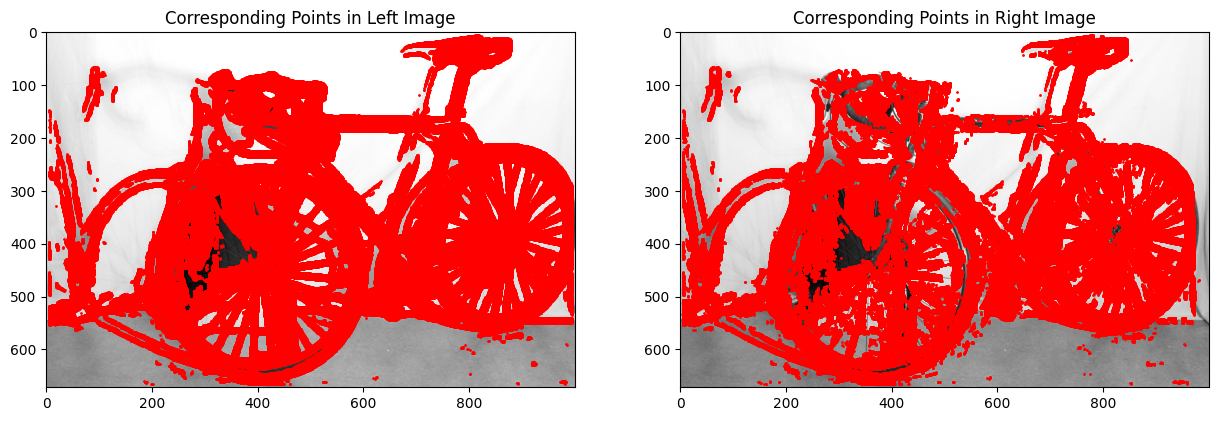

In [10]:
from tqdm import *

def check_block_variance(block, var_threshold):
    return np.mean(np.abs(block - np.mean(block)) < var_threshold) < 0.5

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def find_corresponding_points(imgL, imgR, block_size=5, max_disparity=40):
    h, w = imgL.shape
    disparity_map = np.zeros(imgL.shape, dtype=np.float32)

    # Lists to store the coordinates of corresponding points
    points_left = []
    points_right = []

    for y in tqdm(range(block_size, h - block_size)):
        for x in range(block_size, w - block_size):
            block_left = imgL[y - block_size:y + block_size + 1, x - block_size:x + block_size + 1]

            min_sad = float('inf')
            best_disparity = 0

            # Ensure has_features() returns True for areas with enough texture
            if check_block_variance(block_left, 5):
                for d in range(max_disparity):
                    x_right = x - d
                    if x_right - block_size >= 0:
                        block_right = imgR[y - block_size:y + block_size + 1, x_right - block_size:x_right + block_size + 1]
                        sad = np.sum(np.abs(block_left - block_right))

                        if sad < min_sad:
                            min_sad = sad
                            best_disparity = d

                disparity_map[y, x] = best_disparity

                points_left.append((x, y))
                points_right.append((x - best_disparity, y))

    return disparity_map, np.array(points_left), np.array(points_right)

disparity_map, points_left, points_right = find_corresponding_points(imgL_resized, imgR_resized)

# Visualization
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].imshow(imgL_resized, cmap='gray')
axs[0].scatter(points_left[:, 0], points_left[:, 1], s=1, color='red')
axs[0].set_title('Corresponding Points in Left Image')

axs[1].imshow(imgR_resized, cmap='gray')
axs[1].scatter(points_right[:, 0], points_right[:, 1], s=1, color='red')
axs[1].set_title('Corresponding Points in Right Image')

plt.show()


In [11]:
print(len(points_left))

295809


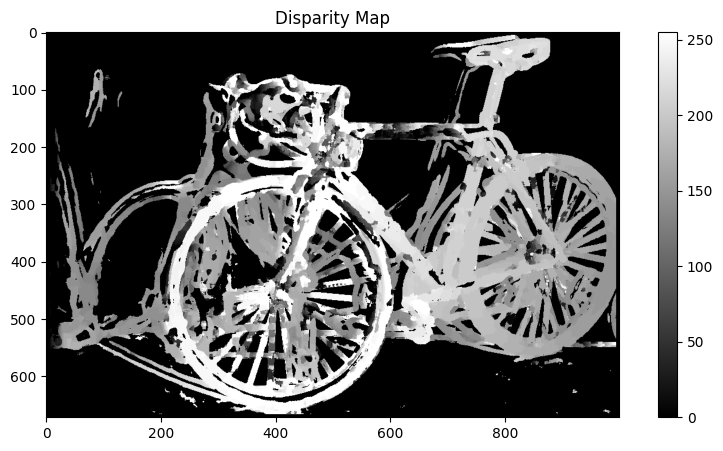

In [12]:

disparity_display = cv2.normalize(disparity_map, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

plt.figure(figsize=(10, 5))
plt.imshow(disparity_display, cmap='gray')
plt.colorbar()
plt.title("Disparity Map")
plt.show()

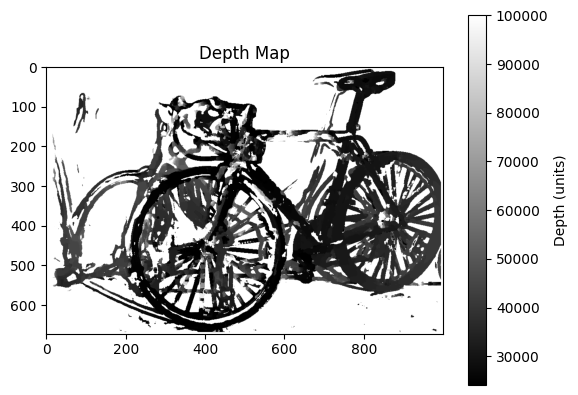

In [17]:
# Define maximum depth value
max_depth = 100000
b = 177.288
f = 5299.313

# Replace zero values in disparity_map with a small number to avoid division by zero
disparity_map[disparity_map == 0] = 1e-6  # Using a small number to replace zero

# Calculate depth map with maximum depth constraint
depth_map = np.minimum((f * b) / disparity_map, max_depth)

# Visualization of the depth map
plt.imshow(depth_map, cmap='gray')
plt.colorbar(label='Depth (units)')
plt.title('Depth Map')
plt.show()

In [14]:
f = 5299.313
cx = 1263.818
cy = 977.763
baseline = 177.288

point_cloud = []

for y in range(depth_map.shape[0]):
    for x in range(depth_map.shape[1]):
        Z = depth_map[y, x]

        # Skip invalid depth
        if np.isinf(Z) or np.isnan(Z):
            continue

        # Convert from pixel coordinates and depth to 3D coordinates
        X = (x - cx) * Z / f
        Y = (y - cy) * Z / f

        # Assuming imgL is a color image; extract RGB color values
        # Ensure imgL is read in color mode if it's being loaded from a file
        color = imgL_resized[y, x] if len(imgL_resized.shape) == 3 else (255,)

        point_cloud.append([X, Y, Z] + list(color))

point_cloud = np.array(point_cloud)



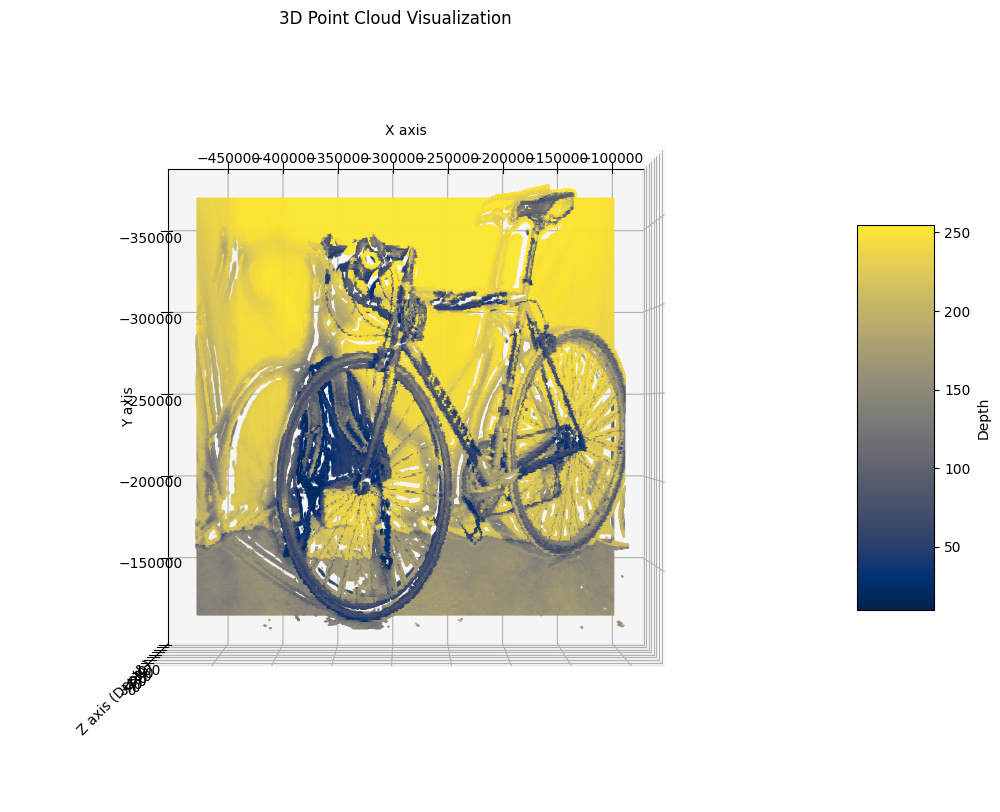

In [15]:
import numpy as np
import cv2

# Camera parameters
f = 5299.313  # Focal length
cx = 1263.818  # Principal point x-coordinate from cam0
cy = 977.763   # Principal point y-coordinate from cam0
b = 177.288    # Baseline in millimeters (or the same units as your depth map)

# Generate a meshgrid of pixel coordinates (u, v) in the image
h, w = depth_map.shape
u, v = np.meshgrid(np.arange(w), np.arange(h))

# Convert depth map from millimeters to meters for compatibility with many visualization tools
depth_map_meters = depth_map / 1000.0

# Back-project to 3D space
Z = depth_map_meters + 2e+06
X = (u - cx) * Z / f
Y = (v - cy) * Z / f

# Combine X, Y, Z coordinates into a single array
points_3D = np.stack((X, Y, Z), axis=-1).reshape(-1, 3)

# Filter out points where depth is inf (no disparity)
points_3D = points_3D[~np.isinf(points_3D).any(axis=1)]

from mpl_toolkits.mplot3d import Axes3D
# Extracting X, Y, Z coordinates for plotting
X = points_3D[:, 0]
Y = points_3D[:, 1]
Z = points_3D[:, 2]

# Creating a 3D scatter plot
fig = plt.figure(figsize=(20, 10))  # Create a figure object
ax = fig.add_subplot(111, projection='3d')  # Add a 3D subplot
colors = imgL_resized[v, u]
# Scatter plot using the X, Y, and Z arrays
scatter = ax.scatter(X, Y, Z, s=1, c=colors, cmap='cividis', marker='.')

# Setting labels and title
ax.set_title('3D Point Cloud Visualization')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis (Depth)')
ax.view_init(elev = -90, azim = -90)

cbar = fig.colorbar(scatter, shrink=0.5, aspect=5)
cbar.set_label('Depth')

plt.show()
